# Predicting flight departure delays at JFK airport leveraging weather factors

**I have preprocessed the Flight and weather datasets separately and merged them, a separate file contains the Exploratory Data Analysis done and features engineered. This file contains the modelling and evaluation**

In [10]:
#All the required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt
from time import time
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

from sklearn.utils import class_weight

In [2]:
#pip install pandas statsmodels scikit-learn imblearn pmdarima
#!pip install xgboost

In [11]:
#Reading the final merged dataset for analysis
data = pd.read_csv("C:/Users/sonal/flight-delay-prediction/dataset/flight_delay_engineered.csv")

In [4]:
data.shape

(170242, 43)

In [5]:
data.head()

,carrier,flight_date,flight_num,dest,scheduled_dep,actual_dep,scheduled_elapsed,actual_elapsed,dep_delay,wheels_off_time,...,delay_category,year,day,month,is_holiday,season,day_of_week,weekend,wind_alert,week
0,AA,2015-01-01,2299,MIA,05:45,06:40,185,199,55,06:57,...,1,2015,1,1,Y,1,Thursday,0,0,1
1,DL,2015-01-01,421,ATL,06:00,06:05,163,139,5,06:23,...,0,2015,1,1,Y,1,Thursday,0,0,1
2,UA,2015-01-01,415,SFO,06:05,06:05,404,400,0,06:25,...,0,2015,1,1,Y,1,Thursday,0,0,1
3,AA,2015-01-01,1441,LAS,06:35,06:56,350,374,21,07:20,...,1,2015,1,1,Y,1,Thursday,0,0,1
4,AA,2015-01-01,2393,MCO,07:00,08:57,185,185,117,09:36,...,2,2015,1,1,Y,1,Thursday,0,0,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170242 entries, 0 to 170241
Data columns (total 44 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   carrier                     170242 non-null  object 
 1   flight_date                 170242 non-null  object 
 2   flight_num                  170242 non-null  int64  
 3   dest                        170242 non-null  object 
 4   scheduled_dep               170242 non-null  object 
 5   actual_dep                  170242 non-null  object 
 6   scheduled_elapsed           170242 non-null  int64  
 7   actual_elapsed              170242 non-null  int64  
 8   dep_delay                   170242 non-null  int64  
 9   wheels_off_time             170242 non-null  object 
 10  taxi_out_time               170242 non-null  int64  
 11  delay_carrier               170242 non-null  int64  
 12  delay_weather               170242 non-null  int64  
 13  delay_aviation

In [6]:
data.describe()

,flight_num,scheduled_elapsed,actual_elapsed,dep_delay,taxi_out_time,delay_carrier,delay_weather,delay_aviation_system,delay_security,delay_late_aircraft,...,wind_gusts_10m,is_day,delay_category,year,day,month,season,weekend,wind_alert,week
count,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,...,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000,170242.000000
mean,1179.032107,279.682875,257.729920,34.438817,27.877891,12.552208,1.960820,7.754256,0.087857,7.602642,...,30.520384,0.715734,0.657540,2018.909452,15.655449,6.376264,2.441665,0.279996,0.006403,25.949237
std,965.078236,106.536305,118.717505,76.154179,17.233558,55.478578,22.636198,29.989942,2.931011,32.100794,...,13.706738,0.451065,0.958675,2.742143,8.719521,3.417327,1.081794,0.448998,0.079760,14.934976
min,1.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.800000,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,420.000000,190.000000,170.000000,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20.500000,0.000000,0.000000,2016.000000,8.000000,3.000000,1.000000,0.000000,0.000000,13.000000
50%,807.000000,273.000000,252.000000,10.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,28.800000,1.000000,0.000000,2019.000000,16.000000,6.000000,2.000000,0.000000,0.000000,26.000000
75%,2175.000000,379.000000,360.000000,34.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,38.500000,1.000000,1.000000,2022.000000,23.000000,9.000000,3.000000,1.000000,0.000000,38.000000
max,8819.000000,1312.000000,769.000000,1757.000000,186.000000,1627.000000,1740.000000,1198.000000,434.000000,1089.000000,...,126.000000,1.000000,4.000000,2024.000000,31.000000,12.000000,4.000000,1.000000,1.000000,53.000000


In [12]:
#Top 20 features as chosen by the SelectKBest method
variables = ['scheduled_elapsed', 'temperature', 'dew_point', 'wind_speed_10m', 'delay_carrier', 'delay_weather', 'carrier',
            'delay_aviation_system', 'delay_security', 'delay_late_aircraft', 'humidity', 'precipitation', 'rain', 'snowfall', 
            'cloud_cover', 'wind_direction_10m', 'wind_gusts_10m', 'year', 'wind_alert', 'weather_code']

numerical_cols = ['scheduled_elapsed', 'temperature', 'dew_point', 'wind_speed_10m', 'delay_carrier', 'delay_weather',
                 'delay_aviation_system', 'delay_security', 'delay_late_aircraft', 'humidity', 'precipitation', 'rain', 'snowfall',
                 'cloud_cover', 'wind_direction_10m', 'wind_gusts_10m']

categorical_cols = ['weather_code', 'carrier', 'year', 'wind_alert']

In [13]:
#PREPROCESSING DATA BEFORE MODELING
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [14]:
# Defining X (features) and y (target)
X = data[variables]
y_log = data['delay_category']

In [15]:
#Splitting data for classification models
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
X_train_log_preprocessed = preprocessor.fit_transform(X_train_log)
X_test_log_preprocessed = preprocessor.transform(X_test_log)

# Baseline Model - Logistic Regression

In [12]:
#Noting start time
start_time_log1 = time()

#Creating the LR model and fitting to training data
logistic_model_test1 = LogisticRegression(random_state=42)
logistic_model_test1.fit(X_train_log_preprocessed, y_train_log)
y_pred_test = logistic_model_test1.predict(X_test_log_preprocessed)

#Noting end time
end_time_log1 = time()
total_time_log1 = end_time_log1 - start_time_log1

# Calculate accuracy on the test set
train_accuracy_log1 = logistic_model_test1.score(X_train_log_preprocessed, y_train_log)
accuracy_log1 = accuracy_score(y_test_log, y_pred_test)
precision_log1 = precision_score(y_test_log, y_pred_test, average='weighted')
recall_log1 = recall_score(y_test_log, y_pred_test, average='weighted')
f1_log1 = f1_score(y_test_log, y_pred_test, average='weighted')
conf_matrix_test_log1 = confusion_matrix(y_test_log, y_pred_test)

# Print evaluation metrics
print("Train Accuracy:", train_accuracy_log1)
print("Test Accuracy:", accuracy_log1)
print("Precision:", precision_log1)
print("Recall:", recall_log1)
print("F1-score:", f1_log1)
print("Confusion Matrix for baseline mode:")
print(conf_matrix_test_log1)

# Print training time
print("Total Training Time:", total_time_log1, "seconds")

Train Accuracy: 0.7827347954740699
Test Accuracy: 0.7817850744515258
Precision: 0.7741355164335872
Recall: 0.7817850744515258
F1-score: 0.7639917234477773
Confusion Matrix for baseline mode:
[[19077   804    19     2     0]
 [ 4526  3936   450    15     0]
 [  279   644  1800   191     0]
 [   28     6   320  1283    37]
 [   11     0     0    98   523]]
Total Training Time: 7.8727943897247314 seconds


Class small ROC AUC: 0.857047987105432
Class moderate ROC AUC: 0.7769375600536392
Class high ROC AUC: 0.953963207803068
Class significant ROC AUC: 0.9849357744841616
Class extreme ROC AUC: 0.9888732446117208
Average ROC AUC: 0.9123515548116042


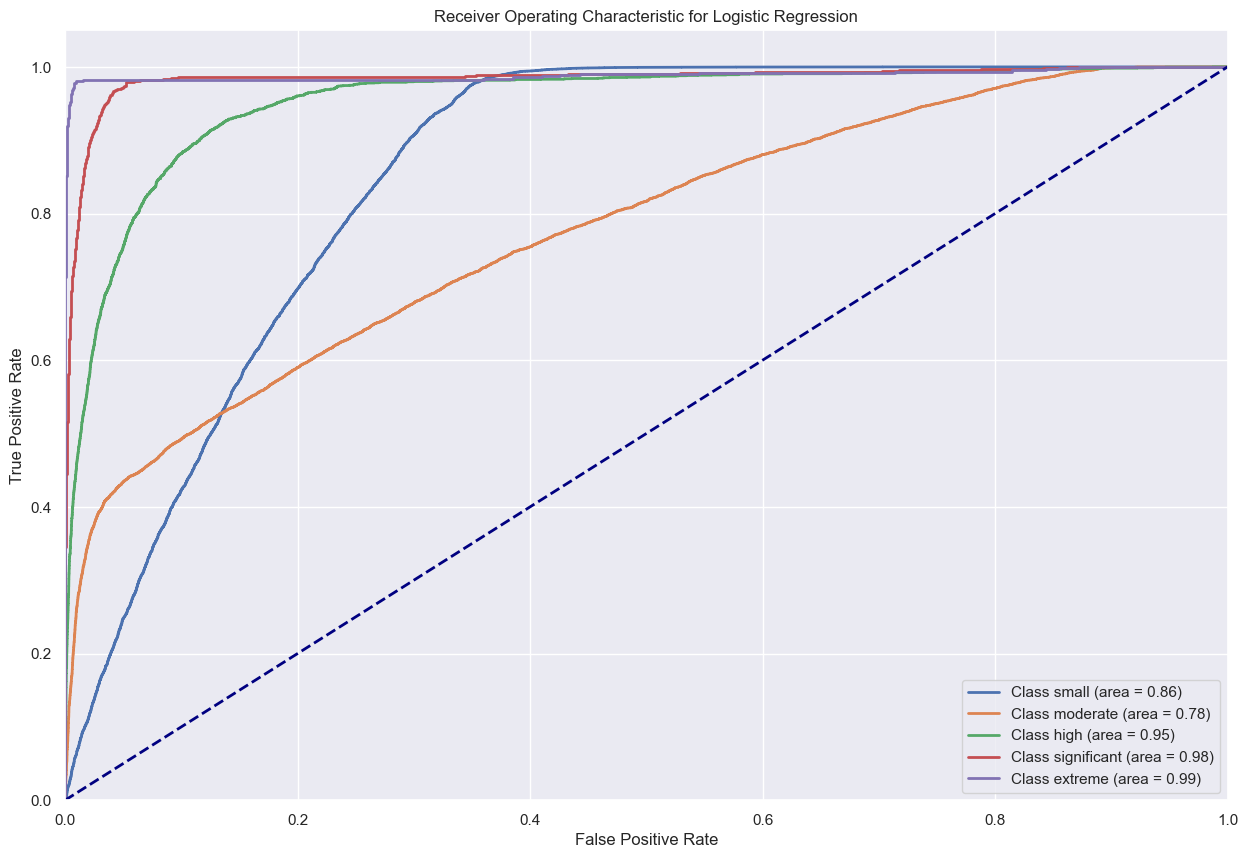

In [13]:
DELAY_CLASSES = [
    (0, 16, "small", 0), 
    (16, 61, "moderate", 1), 
    (61, 121, "high", 2), 
    (121, 241, "significant", 3),
    (241, 1000000, "extreme", 4)
]

#predicting probabilities
y_score_log1 = logistic_model_test1.predict_proba(X_test_log_preprocessed)

#binarizing the labels
n_classes = len(DELAY_CLASSES)
y_test_bin = label_binarize(y_test_log, classes=[0, 1, 2, 3, 4])

#computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_log1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

average_roc_auc_log1 = roc_auc_score(y_test_bin, y_score_log1, average='macro')

for dclass in DELAY_CLASSES:
    _start, _stop, _category, _category_code = dclass
    print(f'Class {_category} ROC AUC: {roc_auc[_category_code]}')
print(f'Average ROC AUC: {average_roc_auc_log1}')

plt.figure(figsize=(15, 10))
lw = 2
for dclass in DELAY_CLASSES:
    _start, _stop, _category, _category_code = dclass
    plt.plot(fpr[_category_code], tpr[_category_code], lw=lw, label=f'Class {_category} (area = {roc_auc[_category_code]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

**Overall the AUC for each delay category is close to 1 and looking at the above ROC curve, the model is able to clearly distinguish Classes from each other**

# Applying Sampling using SMOTE

In [15]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_log_preprocessed, y_train_log)

print(y_train_log.value_counts())
print(y_train_resampled.value_counts())

0    79374
1    35846
2    11803
3     6496
4     2674
Name: delay_category, dtype: int64
0    79374
1    79374
3    79374
2    79374
4    79374
Name: delay_category, dtype: int64


# Logistic Regression Model after Oversampling with SMOTE

In [16]:
logistic_model_SMOTE = LogisticRegression(random_state=42)

logistic_model_SMOTE.fit(X_train_resampled, y_train_resampled)

y_pred_test_SMOTE = logistic_model_SMOTE.predict(X_test_log_preprocessed)

accuracy_test_SMOTE = accuracy_score(y_test_log, y_pred_test_SMOTE)
precision_test_SMOTE = precision_score(y_test_log, y_pred_test_SMOTE, average='weighted')
recall_test_SMOTE = recall_score(y_test_log, y_pred_test_SMOTE, average='weighted')
f1_test_SMOTE = f1_score(y_test_log, y_pred_test_SMOTE, average='weighted')
conf_matrix_SMOTE = confusion_matrix(y_test_log, y_pred_test_SMOTE)

print("Accuracy with SMOTE:", accuracy_test_SMOTE)
print("Precision:", precision_test_SMOTE)
print("Recall:", recall_test_SMOTE)
print("F1-score:", f1_test_SMOTE)
print("Confusion Matrix with SMOTE:")
print(conf_matrix_SMOTE)

Accuracy with SMOTE: 0.7533848277482452
Precision: 0.7418740524629793
Recall: 0.7533848277482452
F1-score: 0.7342867694944979
Confusion Matrix with SMOTE:
[[18293  1473   131     5     0]
 [ 4229  3265  1392    41     0]
 [   94   323  2131   362     4]
 [   21     1   185  1368    99]
 [   11     0     0    26   595]]


# Undersampling with Random Undersampler for Hybrid Sampling

In [17]:
#Applying Hybrid sampling (Random Undersampler over SMOTE) and then reapplying Logistic regression to see performance
rus = RandomUnderSampler(random_state=42)
X_train_hybrid, y_train_hybrid = rus.fit_resample(X_train_resampled, y_train_resampled)

# Logistic Regression after Hybrid Sampling

In [18]:
#Noting start time
start_time_log2 = time()

logistic_model_rus = LogisticRegression(random_state=42)
logistic_model_rus.fit(X_train_hybrid, y_train_hybrid)
y_pred_test_hybrid = logistic_model_rus.predict(X_test_log_preprocessed)

#Noting end time
end_time_log2 = time()
total_time_log2 = end_time_log2 - start_time_log2

train_accuracy_test_hybrid = logistic_model_rus.score(X_train_log_preprocessed, y_train_log)
accuracy_test_hybrid = accuracy_score(y_test_log, y_pred_test_hybrid)
precision_test_hybrid = precision_score(y_test_log, y_pred_test_hybrid, average='weighted')
recall_test_hybrid = recall_score(y_test_log, y_pred_test_hybrid, average='weighted')
f1_test_hybrid = f1_score(y_test_log, y_pred_test_hybrid, average='weighted')
conf_matrix_hybrid = confusion_matrix(y_test_log, y_pred_test_hybrid)

print("Train Accuracy:", train_accuracy_test_hybrid)
print("Accuracy with Hybrid sampling:", accuracy_test_hybrid)
print("Precision:", precision_test_hybrid)
print("Recall:", recall_test_hybrid)
print("F1-score:", f1_test_hybrid)
print("Confusion Matrix with Hybrid Sampling:")
print(conf_matrix_hybrid)

Train Accuracy: 0.753922741991145
Accuracy with Hybrid sampling: 0.7533848277482452
Precision: 0.7418740524629793
Recall: 0.7533848277482452
F1-score: 0.7342867694944979
Confusion Matrix with Hybrid Sampling:
[[18293  1473   131     5     0]
 [ 4229  3265  1392    41     0]
 [   94   323  2131   362     4]
 [   21     1   185  1368    99]
 [   11     0     0    26   595]]


Class small ROC AUC: 0.8576513855475771
Class moderate ROC AUC: 0.7304512286304735
Class high ROC AUC: 0.9475253724371439
Class significant ROC AUC: 0.9844635787861594
Class extreme ROC AUC: 0.989155068878381
Average ROC AUC: 0.9018493268559471


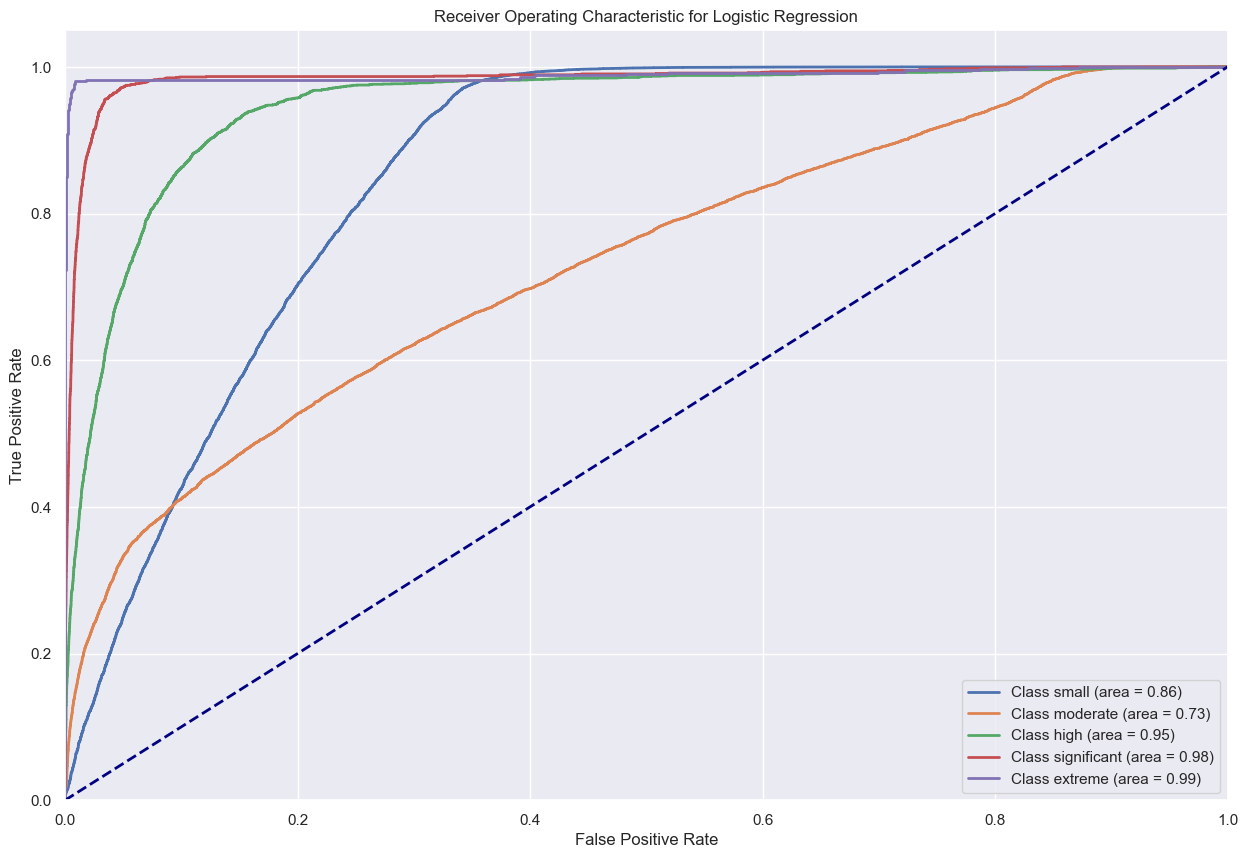

In [19]:
# Define delay classes
DELAY_CLASSES = [
    (0, 16, "small", 0), 
    (16, 61, "moderate", 1), 
    (61, 121, "high", 2), 
    (121, 241, "significant", 3),
    (241, 1000000, "extreme", 4)
]

y_score_log2 = logistic_model_rus.predict_proba(X_test_log_preprocessed)

n_classes = len(DELAY_CLASSES)
y_test_bin = label_binarize(y_test_log, classes=[0, 1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_log2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

average_roc_auc_log2 = roc_auc_score(y_test_bin, y_score_log2, average='macro')

for dclass in DELAY_CLASSES:
    _start, _stop, _category, _category_code = dclass
    print(f'Class {_category} ROC AUC: {roc_auc[_category_code]}')
print(f'Average ROC AUC: {average_roc_auc_log2}')

plt.figure(figsize=(15, 10))
lw = 2
for dclass in DELAY_CLASSES:
    _start, _stop, _category, _category_code = dclass
    plt.plot(fpr[_category_code], tpr[_category_code], lw=lw, label=f'Class {_category} (area = {roc_auc[_category_code]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Random Forest Classifier Ensemble model

In [20]:
#creating a random forest classifier model
start_time_rf = time()

#rf_model = RandomForestClassifier(n_estimators=100, random_state=42) 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
rf_model.fit(X_train_log_preprocessed, y_train_log)
y_pred_rf = rf_model.predict(X_test_log_preprocessed)

end_time_rf = time()
total_time_rf = end_time_rf - start_time_rf

#Checking evaluation metrics
train_accuracy_rf = rf_model.score(X_train_log_preprocessed, y_train_log)
accuracy_rf = accuracy_score(y_test_log, y_pred_rf)
precision_rf = precision_score(y_test_log, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test_log, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test_log, y_pred_rf, average='weighted')

print("Train Accuracy:", train_accuracy_rf)
print("Accuracy with Random Forest:", accuracy_rf)
print("Precision with Random Forest:", precision_rf)
print("Recall with Random Forest:", recall_rf)
print("F1 Score with Random Forest:", f1_rf)

#Classification report
print("\nClassification Report:")
print(classification_report(y_test_log, y_pred_rf))

#OOB score
print("OOB Score with Random Forest:", rf_model.oob_score_) #generalization accuracy check

#training time
print("Total Training Time:", total_time_rf, "seconds")

#Confusion matrix
conf_matrix_rf = confusion_matrix(y_test_log, y_pred_rf)

Train Accuracy: 0.9995888188086025
Accuracy with Random Forest: 0.7926811360098681
Precision with Random Forest: 0.7856781621014944
Recall with Random Forest: 0.7926811360098681
F1 Score with Random Forest: 0.7828707551926899

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87     19902
           1       0.70      0.53      0.60      8927
           2       0.79      0.70      0.74      2914
           3       0.82      0.78      0.80      1674
           4       0.92      0.65      0.76       632

    accuracy                           0.79     34049
   macro avg       0.81      0.72      0.76     34049
weighted avg       0.79      0.79      0.78     34049

OOB Score with Random Forest: 0.7906794034935716
Total Training Time: 112.59453630447388 seconds


Class small ROC AUC: 0.8668901079628911
Class moderate ROC AUC: 0.7832189846672468
Class high ROC AUC: 0.9652243164936187
Class significant ROC AUC: 0.9850665873246518
Class extreme ROC AUC: 0.9918077776679268
Average ROC AUC: 0.9184415548232672


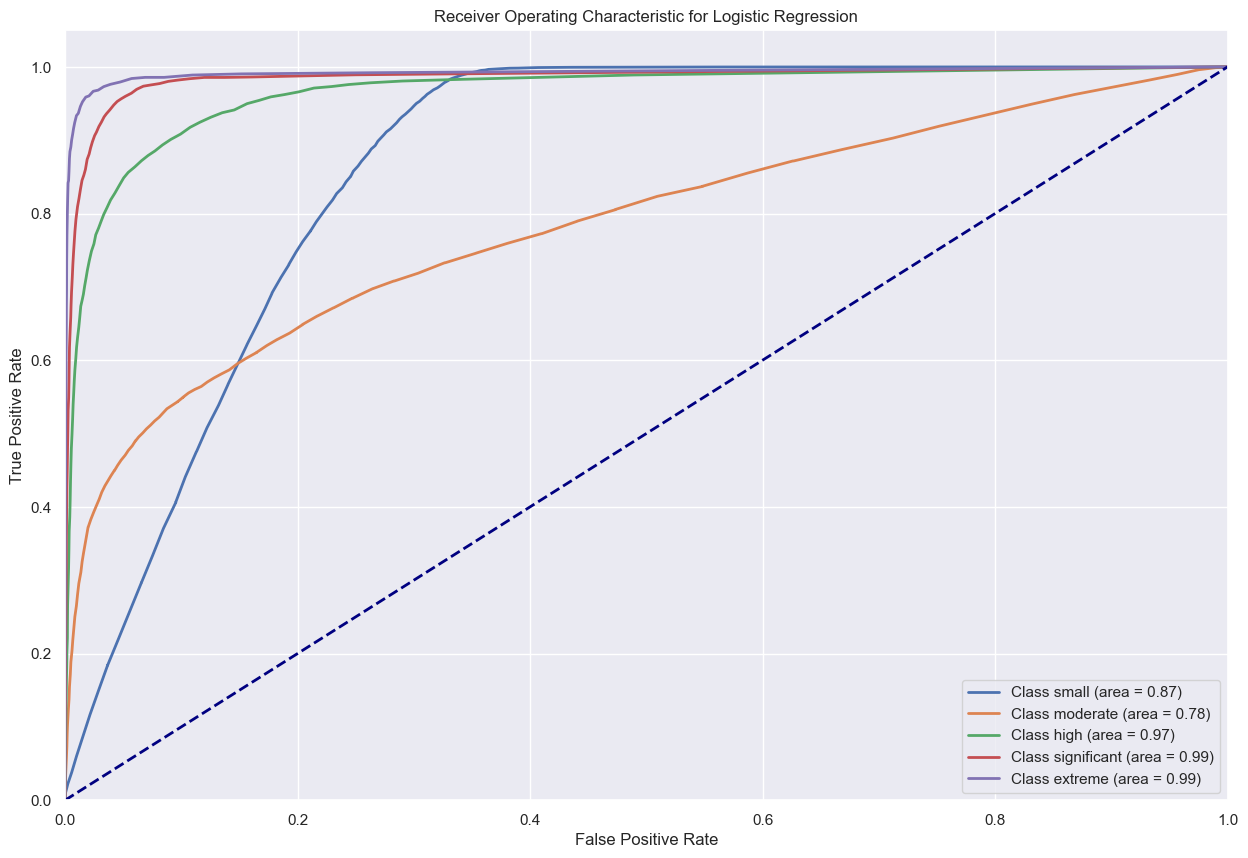

In [21]:
DELAY_CLASSES = [
    (0, 16, "small", 0), 
    (16, 61, "moderate", 1), 
    (61, 121, "high", 2), 
    (121, 241, "significant", 3),
    (241, 1000000, "extreme", 4)
]

#Predicting probabilities
y_score_rf = rf_model.predict_proba(X_test_log_preprocessed)

n_classes = len(DELAY_CLASSES)
y_test_bin = label_binarize(y_test_log, classes=[0, 1, 2, 3, 4])

#Computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Computing the avg ROC AUC
average_roc_auc_rf = roc_auc_score(y_test_bin, y_score_rf, average='macro')

for dclass in DELAY_CLASSES:
    _start, _stop, _category, _category_code = dclass
    print(f'Class {_category} ROC AUC: {roc_auc[_category_code]}')
print(f'Average ROC AUC: {average_roc_auc_rf}')

plt.figure(figsize=(15, 10))
lw = 2
for dclass in DELAY_CLASSES:
    _start, _stop, _category, _category_code = dclass
    plt.plot(fpr[_category_code], tpr[_category_code], lw=lw, label=f'Class {_category} (area = {roc_auc[_category_code]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# XGBoost Classifier

In [22]:
start_time_xgb = time()

xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_log_preprocessed, y_train_log)
y_pred_xgb = xgb_model.predict(X_test_log_preprocessed)

end_time_xgb = time()
total_time_xgb = end_time_xgb - start_time_xgb

#Checking evaluation metrics
train_accuracy_xgb = xgb_model.score(X_train_log_preprocessed, y_train_log)
accuracy_xgb = accuracy_score(y_test_log, y_pred_xgb)
precision_xgb = precision_score(y_test_log, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test_log, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test_log, y_pred_xgb, average='weighted')

print("Train Accuracy:", train_accuracy_xgb)
print("Accuracy with XGBoost:", accuracy_xgb)
print("Precision with XGBoost:", precision_xgb)
print("Recall with XGBoost:", recall_xgb)
print("F1 Score with XGBoost:", f1_xgb)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_log, y_pred_xgb))

print("Total Training Time:", total_time_xgb, "seconds")

#Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test_log, y_pred_xgb)

Train Accuracy: 0.8442210686305464
Accuracy with XGBoost: 0.8263385121442627
Precision with XGBoost: 0.834689404897293
Recall with XGBoost: 0.8263385121442627
F1 Score with XGBoost: 0.8091143159738816

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     19902
           1       0.88      0.47      0.61      8927
           2       0.82      0.75      0.78      2914
           3       0.88      0.85      0.86      1674
           4       0.95      0.88      0.91       632

    accuracy                           0.83     34049
   macro avg       0.87      0.79      0.81     34049
weighted avg       0.83      0.83      0.81     34049

Total Training Time: 10.52267575263977 seconds


Class small ROC AUC: 0.885014767383861
Class moderate ROC AUC: 0.8327316409375813
Class high ROC AUC: 0.9784446460986038
Class significant ROC AUC: 0.9907689440592665
Class extreme ROC AUC: 0.9952535433530194
Average ROC AUC: 0.9364427083664664


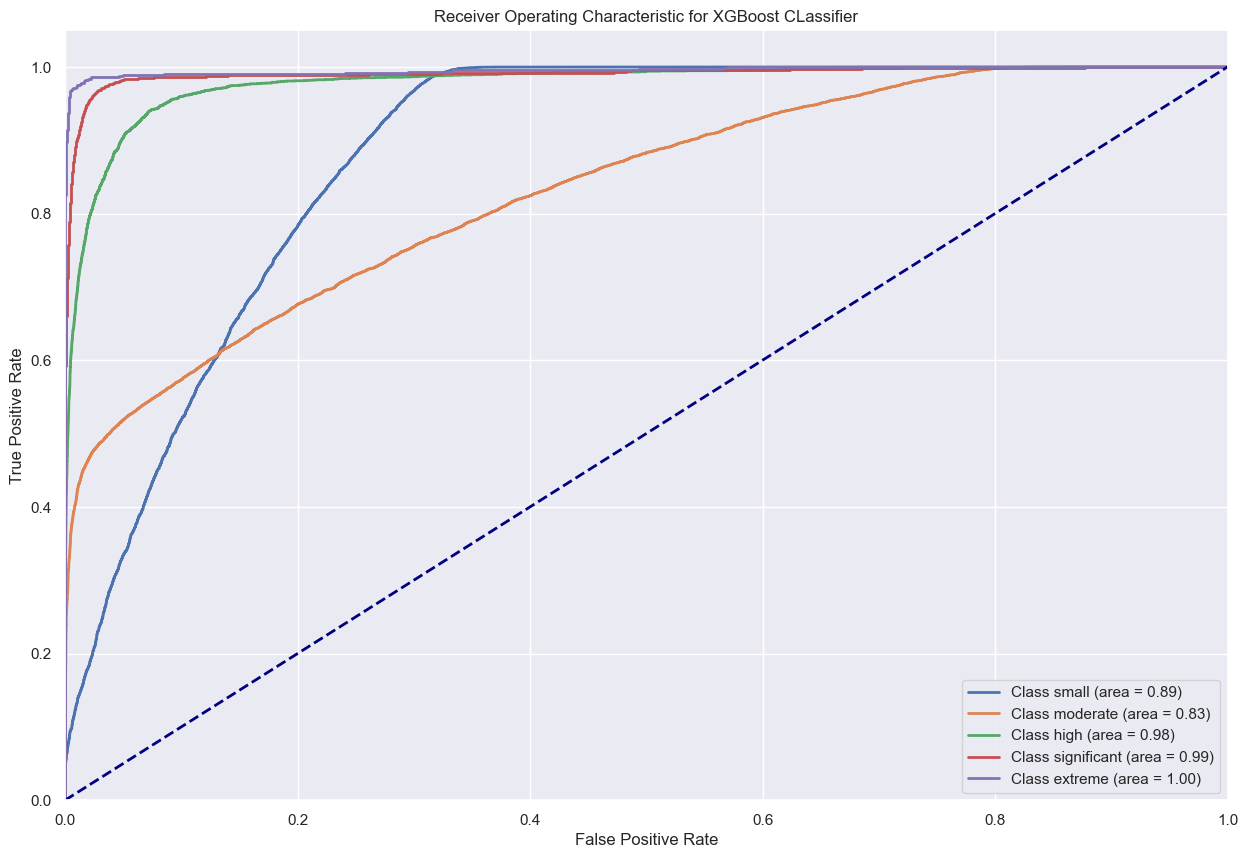

In [24]:
DELAY_CLASSES = [
    (0, 16, "small", 0), 
    (16, 61, "moderate", 1), 
    (61, 121, "high", 2), 
    (121, 241, "significant", 3),
    (241, 1000000, "extreme", 4)
]

y_score_xgb = xgb_model.predict_proba(X_test_log_preprocessed)

n_classes = len(DELAY_CLASSES)
y_test_bin = label_binarize(y_test_log, classes=[0, 1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_xgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

average_roc_auc_xgb = roc_auc_score(y_test_bin, y_score_xgb, average='macro')

for dclass in DELAY_CLASSES:
    _start, _stop, _category, _category_code = dclass
    print(f'Class {_category} ROC AUC: {roc_auc[_category_code]:}')
print(f'Average ROC AUC: {average_roc_auc_xgb}')

plt.figure(figsize=(15, 10))
lw = 2
for dclass in DELAY_CLASSES:
    _start, _stop, _category, _category_code = dclass
    plt.plot(fpr[_category_code], tpr[_category_code], lw=lw, label=f'Class {_category} (area = {roc_auc[_category_code]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for XGBoost CLassifier')
plt.legend(loc="lower right")
plt.show()

# Hyperparameter Tuning with Cross validation for Random Forest

In [24]:
#Tried GridSearchCV but it is computationally expensive and also takes forever to run. GridSearchCV performs the following
#multiple times. Training RF with specific number of trees, validating model's performance using 5 fold cross validation, 
#repeating the process for number of parameters given.

#grid_search = GridSearchCV(rf_model_grid, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

#using Randomized Search CV instead to sample a fixed number of combinations.

# Hyperparameter Tuning for Random Forest using RandomSearchCV

In [ ]:
#Takes 8 hrs to run on Jupyter
param_grid = {'n_estimators': [50, 100, 150, 200]}

rf_model_grid = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf_model_grid, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=42)
random_search.fit(X_train_log_preprocessed, y_train_log)

best_n_estimators = random_search.best_params_['n_estimators']

best_n_estimators

#came as 200 from params 50,100,150,200; reminder to manually set if running the entire code and comment above code
best_n_estimators = 200

In [27]:
#Took about 30 minutes to run
start_time_RSCV = time()

best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
best_rf_model.fit(X_train_log_preprocessed, y_train_log)

#Using trained model to make predictions on new data
y_pred_rfbest = best_rf_model.predict(X_test_log_preprocessed)

end_time_RSCV = time()
total_time_RSCV = end_time_RSCV - start_time_RSCV

train_accuracy_rfbest = best_rf_model.score(X_train_log_preprocessed, y_train_log)
accuracy_rfbest = accuracy_score(y_test_log, y_pred_rfbest)
precision_rfbest = precision_score(y_test_log, y_pred_rfbest, average='weighted')
recall_rfbest = recall_score(y_test_log, y_pred_rfbest, average='weighted')
f1_rfbest = f1_score(y_test_log, y_pred_rfbest, average='weighted')

print("Train Accuracy:", train_accuracy_rfbest)
print("Accuracy with Random Forest:", accuracy_rfbest)
print("Precision with Random Forest:", precision_rfbest)
print("Recall with Random Forest:", recall_rfbest)
print("F1 Score with Random Forest:", f1_rfbest)

print("\nClassification Report:")
print(classification_report(y_test_log, y_pred_rfbest))

#Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test_log, y_pred_rfbest)

print("Total Training Time:", total_time_RSCV, "seconds")

Train Accuracy: 0.9996035038511524
Accuracy with Random Forest: 0.7958236658932715
Precision with Random Forest: 0.7891984685428027
Recall with Random Forest: 0.7958236658932715
F1 Score with Random Forest: 0.7862952082649918

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     19902
           1       0.71      0.53      0.61      8927
           2       0.81      0.71      0.76      2914
           3       0.82      0.80      0.81      1674
           4       0.93      0.66      0.77       632

    accuracy                           0.80     34049
   macro avg       0.82      0.73      0.76     34049
weighted avg       0.79      0.80      0.79     34049

Total Training Time: 205.66162753105164 seconds


# Hyperparameter Tuning for Logistic Regression using 10-fold Cross validation

In [ ]:
# THIS CODE TAKES FOREVER TO RUN COMMENT BEFORE RUNNING ALL

# Define the parameters grid
parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4], "penalty": ['l1', 'l2']}]

# Define a scorer for F1 score with 'macro' averaging
scorer = make_scorer(f1_score, average='macro')

# Initialize GridSearchCV with logistic regression model, parameters grid, and F1 scorer
model = GridSearchCV(LogisticRegression(solver='liblinear'), parameters, cv=10, scoring=scorer)

# Fit the model
model.fit(X_train_log_preprocessed, y_train_log)

# Print the best parameters
print("Best parameters for models by cross-validation are:", model.best_estimator_)

# Calculate F1 score on the training data
train_f1_score = f1_score(y_train_log, model.predict(X_train_log_preprocessed), average='macro')
print("F1 Score on training data:", train_f1_score)

In [30]:
#HYPERPARAMETER TUNING WITH BEST PARAMETERS FROM 10 FOLD CV
start_time_log3 = time()

log_reg_CV = LogisticRegression(C=10000,penalty='l1',solver = 'liblinear')
log_reg_CV.fit(X_train_log_preprocessed, y_train_log)
y_pred_log_CV = log_reg_CV.predict(X_test_log_preprocessed)

end_time_log3 = time()
total_time_log3 = end_time_log3 - start_time_log3

train_accuracy_log3 = log_reg_CV.score(X_train_log_preprocessed, y_train_log)
accuracy_log_CV = accuracy_score(y_test_log, y_pred_log_CV)
precision_log_CV = precision_score(y_test_log, y_pred_log_CV, average='weighted')
recall_log_CV = recall_score(y_test_log, y_pred_log_CV, average='weighted')
f1_log_CV = f1_score(y_test_log, y_pred_log_CV, average='weighted')

print("Train Accuracy:", train_accuracy_log3)
print("Accuracy for Log Reg CV:", accuracy_log_CV)
print("Precision for Log Reg CV:", precision_log_CV)
print("Recall for Log Reg CV:", recall_log_CV)
print("F1 Score for Log Reg CV:", f1_log_CV)

#Confusion matrix
conf_matrix_log3 = confusion_matrix(y_test_log, y_pred_log_CV)

print("Total Training Time:", total_time_log3, "seconds")

Train Accuracy: 0.7212999199665181
Accuracy for Log Reg CV: 0.722781873182766
Precision for Log Reg CV: 0.6769736381614936
Recall for Log Reg CV: 0.722781873182766
F1 Score for Log Reg CV: 0.6740133539404652
Total Training Time: 42.38259983062744 seconds


# Hyperparameter Tuning for XGBoost Classifier with RandomizedSearchCV

In [16]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5)
}

xgb_model_CV = XGBClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=xgb_model_CV, param_distributions=param_dist,
                                   n_iter=100, scoring='accuracy', cv=5, verbose=2, n_jobs=-1, random_state=42)

start_time_xgb_CV = time()
random_search.fit(X_train_log_preprocessed, y_train_log)
end_time_xgb_CV = time()
total_time_xgb_CV = end_time_xgb_CV - start_time_xgb_CV

best_params = random_search.best_params_
best_model = random_search.best_estimator_

y_score_xgb_CV = best_model.predict(X_test_log_preprocessed)

train_accuracy_xgb_CV = best_model.score(X_train_log_preprocessed, y_train_log)
accuracy_xgb_CV = accuracy_score(y_test_log, y_score_xgb_CV)
precision_xgb_CV = precision_score(y_test_log, y_score_xgb_CV, average='weighted')
recall_xgb_CV = recall_score(y_test_log, y_score_xgb_CV, average='weighted')
f1_xgb_CV = f1_score(y_test_log, y_score_xgb_CV, average='weighted')

print("Best Parameters:", best_params)
print("Train Accuracy:", train_accuracy_xgb_CV)
print("Accuracy with XGBoost:", accuracy_xgb_CV)
print("Precision with XGBoost:", precision_xgb_CV)
print("Recall with XGBoost:", recall_xgb_CV)
print("F1 Score with XGBoost:", f1_xgb_CV)
print("Total Training Time:", total_time_xgb_CV, "seconds")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_log, y_score_xgb_CV))

# Confusion matrix
conf_matrix_xgb_CV = confusion_matrix(y_test_log, y_score_xgb_CV)
print("\nConfusion Matrix:")
print(conf_matrix_xgb_CV)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'colsample_bytree': 0.8447411578889518, 'gamma': 0.06974693032602092, 'learning_rate': 0.09764339456056544, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.7529847965068651}
Train Accuracy: 0.8470405968001292
Accuracy with XGBoost: 0.8269259009075156
Precision with XGBoost: 0.8359773704915459
Recall with XGBoost: 0.8269259009075156
F1 Score with XGBoost: 0.8096372526827187
Total Training Time: 2459.235242128372 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     19902
           1       0.88      0.47      0.61      8927
           2       0.83      0.75      0.79      2914
           3       0.89      0.84      0.86      1674
           4       0.95      0.89      0.92       632

    accuracy                           0.83     34049
   macro avg       0.87      0.79      0.82     34049
weighted avg       0.84      0.83 

Class small ROC AUC: 0.88575400319699
Class moderate ROC AUC: 0.8342101455616877
Class high ROC AUC: 0.9788530674143718
Class significant ROC AUC: 0.990957187602349
Class extreme ROC AUC: 0.9936978752950347
Average ROC AUC: 0.9366944558140867


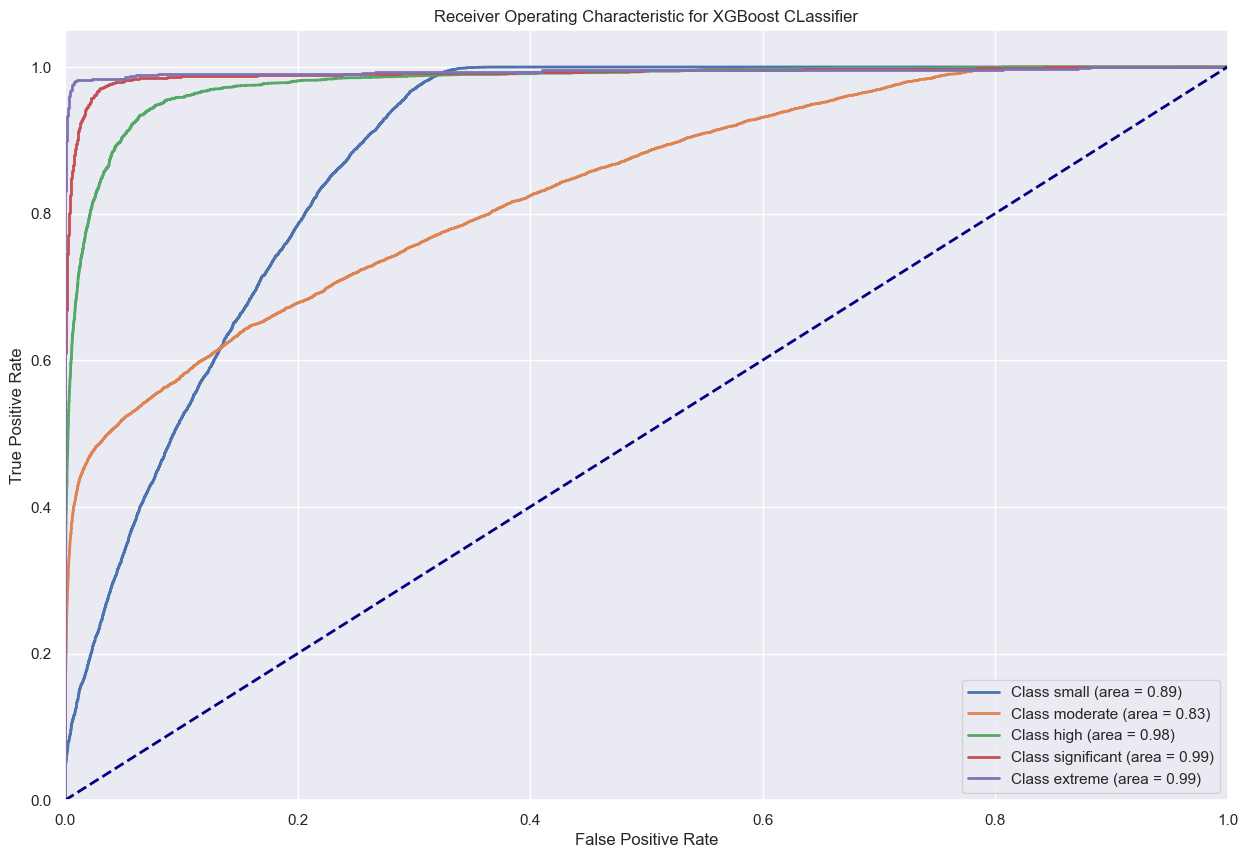

In [18]:
DELAY_CLASSES = [
    (0, 16, "small", 0), 
    (16, 61, "moderate", 1), 
    (61, 121, "high", 2), 
    (121, 241, "significant", 3),
    (241, 1000000, "extreme", 4)
]

y_score_xgb_CV = best_model.predict_proba(X_test_log_preprocessed)

n_classes = len(DELAY_CLASSES)
y_test_bin = label_binarize(y_test_log, classes=[0, 1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_xgb_CV[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

average_roc_auc_xgb_CV = roc_auc_score(y_test_bin, y_score_xgb_CV, average='macro')

for dclass in DELAY_CLASSES:
    _start, _stop, _category, _category_code = dclass
    print(f'Class {_category} ROC AUC: {roc_auc[_category_code]:}')
print(f'Average ROC AUC: {average_roc_auc_xgb_CV}')

plt.figure(figsize=(15, 10))
lw = 2
for dclass in DELAY_CLASSES:
    _start, _stop, _category, _category_code = dclass
    plt.plot(fpr[_category_code], tpr[_category_code], lw=lw, label=f'Class {_category} (area = {roc_auc[_category_code]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for XGBoost CLassifier')
plt.legend(loc="lower right")
plt.show()

In [32]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Logistic Regression with Hybrid Sampling','Random Forest', 'XGBoost Classifier','Logistic Regression with 10-fold CV', 'Random Forest with RandomSearchCV', 'XGBoost Classifier with RandomSEarchCV'],
    'F1-Score': [f1_log1, f1_test_hybrid, f1_rf, f1_xgb, f1_rfbest, f1_log_CV, f1_xgb_CV],
    'Train Accuracy': [train_accuracy_log1*100, train_accuracy_test_hybrid*100, train_accuracy_rf*100, train_accuracy_xgb*100, train_accuracy_rfbest*100, train_accuracy_log3*100, train_accuracy_xgb_CV*100],
    'Test Accuracy': [accuracy_log1*100, accuracy_test_hybrid*100, accuracy_rf*100, accuracy_xgb*100, accuracy_rfbest*100, accuracy_log_CV*100, accuracy_xgb_CV*100]})
models.sort_values(by='F1-Score', ascending=False)

,Model,F1-Score,Train Accuracy,Test Accuracy
6,XGBoost Classifier with RandomSEarchCV,0.809637,84.704060,82.692590
3,XGBoost Classifier,0.809114,84.422107,82.633851
4,Logistic Regression with 10-fold CV,0.786295,99.960350,79.582367
2,Random Forest,0.782871,99.958882,79.268114
0,Logistic Regression,0.763992,78.273480,78.178507
1,Logistic Regression with Hybrid Sampling,0.734287,75.392274,75.338483
5,Random Forest with RandomSearchCV,0.674013,72.129992,72.278187


In [33]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Logistic Regression with Hybrid Sampling','Random Forest', 'XGBoost Classifier','Logistic Regression with 10-fold CV', 'Random Forest with RandomSearchCV', 'XGBoost with RandomSearchCV'],
    'F1-Score': [f1_log1, f1_test_hybrid, f1_rf, f1_xgb, f1_rfbest, f1_log_CV, f1_xgb_CV],
    'Train Accuracy': [train_accuracy_log1*100, train_accuracy_test_hybrid*100, train_accuracy_rf*100, train_accuracy_xgb*100, train_accuracy_rfbest*100, train_accuracy_log3*100, train_accuracy_xgb_CV*100],
    'Test Accuracy': [accuracy_log1*100, accuracy_test_hybrid*100, accuracy_rf*100, accuracy_xgb*100, accuracy_rfbest*100, accuracy_log_CV*100, accuracy_xgb_CV*100],
    'Precision':[precision_log1*100, precision_test_hybrid*100, precision_rf*100, precision_xgb*100, precision_rfbest*100, precision_log_CV*100, precision_xgb_CV*100],
    'Recall':[recall_log1*100, recall_test_hybrid*100, recall_rf*100, recall_xgb*100, recall_rfbest*100, recall_log_CV*100, recall_xgb_CV*100]
})
models.sort_values(by='F1-Score', ascending=False)

,Model,F1-Score,Train Accuracy,Test Accuracy,Precision,Recall
6,XGBoost with RandomSearchCV,0.809637,84.704060,82.692590,83.597737,82.692590
3,XGBoost Classifier,0.809114,84.422107,82.633851,83.468940,82.633851
4,Logistic Regression with 10-fold CV,0.786295,99.960350,79.582367,78.919847,79.582367
2,Random Forest,0.782871,99.958882,79.268114,78.567816,79.268114
0,Logistic Regression,0.763992,78.273480,78.178507,77.413552,78.178507
1,Logistic Regression with Hybrid Sampling,0.734287,75.392274,75.338483,74.187405,75.338483
5,Random Forest with RandomSearchCV,0.674013,72.129992,72.278187,67.697364,72.278187
